# MNIST FROM PURE NUMPY

Dongmin kim

## Set Hyperparameters

In [1]:
VALIDATION_RATIO = 0.2
BATCH_SIZE = 100
LEARNING_RATE = 1e-5
EPOCHS = 100



## Load Dataset

Download 4 files from:
http://yann.lecun.com/exdb/mnist/

In [2]:
import os

In [3]:
path = "/content/drive/My Drive/Colab Notebooks/mnist_from_scratch"
os.listdir(path)

['t10k-labels-idx1-ubyte',
 't10k-images-idx3-ubyte',
 'train-labels-idx1-ubyte',
 'train-images-idx3-ubyte',
 'mnist_from_scratch.ipynb',
 'mnist_from_numpy.ipynb']

In [4]:
# locate files
train_image_source = os.path.join(path, "train-images-idx3-ubyte")
train_label_source = os.path.join(path, "train-labels-idx1-ubyte")
test_image_source = os.path.join(path, "t10k-images-idx3-ubyte")
test_label_source = os.path.join(path, "t10k-labels-idx1-ubyte")

In [5]:
import numpy as np
import struct
from array import array
import matplotlib.pyplot as plt

# Mnist Loader Module
class MnistDataloader(object):
  def __init__(self, training_images_filepath, training_labels_filepath,
                test_images_filepath, test_labels_filepath):
      self.training_images_filepath = training_images_filepath
      self.training_labels_filepath = training_labels_filepath
      self.test_images_filepath = test_images_filepath
      self.test_labels_filepath = test_labels_filepath

  def get_file_stat(self, source, is_img, desc = None):
    print("==", desc, "==")
    total = os.path.getsize(source)
    header = 16 if is_img else 8
    data_size = total - header
    data_cnt = data_size // 784 if is_img else data_size
    print("TOTAL SIZE: ", total)
    print("HEADER: ", header)
    print("DATA SIZE: ", data_size)
    print("DATA COUNT: ", data_cnt)
    return data_cnt

  def read_images_labels(self, images_filepath, labels_filepath):
    '''
      Read images, labels
    '''
    # labels
    labels = []

    '''
    http://yann.lecun.com/exdb/mnist/, file formats for mnist
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    '''
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8)) # in Big Endian, read two unsigned ints
        if magic != 2049:
            raise ValueError('Expected 2049, got {}'.format(magic))
        labels = array("B", file.read())

    #images
    '''
    http://yann.lecun.com/exdb/mnist/, file formats for mnist
    [offset] [type]          [value]          [description]
      0000     32 bit integer  0x00000803(2051) magic number
      0004     32 bit integer  60000            number of images
      0008     32 bit integer  28               number of rows
      0012     32 bit integer  28               number of columns
      0016     unsigned byte   ??               pixel
      0017     unsigned byte   ??               pixel
      ........
      xxxx     unsigned byte   ??               pixel
    '''
    with open(images_filepath, 'rb') as file:
      magic, size, rows, cols = struct.unpack(">IIII", file.read(16)) # in Big Endian, read four unsigned ints
      if magic != 2051:
          raise ValueError('Expected 2051, got {}'.format(magic))
      image_data = array("B", file.read())        
    
    images = []
    for i in range(size):
      imsize = rows * cols
      img = np.array(image_data[i * imsize : (i + 1) * imsize])
      img = img.reshape(28, 28, 1)
      img = np.transpose(img, (2, 0, 1))
      images.append(img)
    
    '''
      To numpy
    '''
    images = np.array(images)
    labels = np.eye(10)[np.array(labels).reshape(-1)] # one hot
                
    return images, labels
          
  def load_data(self, validation_ratio = 0):
    '''
        Sanity Checks
    '''
    tr_im_cnt = self.get_file_stat(self.training_images_filepath, 1, "TRAIN_IMAGE")
    tr_lb_cnt = self.get_file_stat(self.training_labels_filepath, 0, "TRAIN_LABEL")
    assert(tr_im_cnt == tr_lb_cnt) # check if the number of images equals the number labels

    te_im_cnt = self.get_file_stat(self.test_images_filepath, 1, "TEST_IMAGE")
    te_lb_cnt = self.get_file_stat(self.test_labels_filepath, 0, "TEST_LABEL")
    assert(te_im_cnt == te_lb_cnt) # check if the number of images equals the number labels
    
    '''
      load data
    '''
    x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
    x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)

    '''
      train/validation split
    '''
    assert(validation_ratio >= 0 and validation_ratio <= 1)

    if validation_ratio == 0:
      return (x_train, y_train),(x_test, y_test)
    else:
      val_length = int(len(x_train) * VALIDATION_RATIO)
      x_validation = x_train[:val_length]
      x_train = x_train[val_length:]
      y_validation = y_train[:val_length]
      y_train = y_train[val_length:]
      return (x_train, y_train),(x_test, y_test), (x_validation, y_validation)

In [6]:
mnist_dataloader = MnistDataloader(train_image_source, train_label_source, test_image_source, test_label_source)
(x_train, y_train), (x_test, y_test), (x_validation, y_validation) = mnist_dataloader.load_data(validation_ratio = VALIDATION_RATIO)

== TRAIN_IMAGE ==
TOTAL SIZE:  47040016
HEADER:  16
DATA SIZE:  47040000
DATA COUNT:  60000
== TRAIN_LABEL ==
TOTAL SIZE:  60008
HEADER:  8
DATA SIZE:  60000
DATA COUNT:  60000
== TEST_IMAGE ==
TOTAL SIZE:  7840016
HEADER:  16
DATA SIZE:  7840000
DATA COUNT:  10000
== TEST_LABEL ==
TOTAL SIZE:  10008
HEADER:  8
DATA SIZE:  10000
DATA COUNT:  10000


In [7]:
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_validation))
print(np.shape(y_validation))
print(np.shape(x_test))
print(np.shape(y_test))

(48000, 1, 28, 28)
(48000, 10)
(12000, 1, 28, 28)
(12000, 10)
(10000, 1, 28, 28)
(10000, 10)


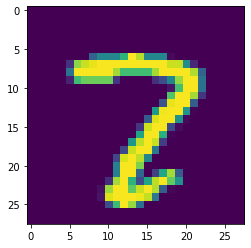

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [8]:
plt.imshow(x_train[0].reshape(28, 28))
plt.show()
print(y_train[0])

## Modeling

In [9]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):

  N, C, H, W = input_data.shape
  out_h = (H + 2*pad - filter_h)//stride + 1
  out_w = (W + 2*pad - filter_w)//stride + 1

  img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
  col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
  for y in range(filter_h):
      y_max = y + stride*out_h
      for x in range(filter_w):
          x_max = x + stride*out_w
          col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

  col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
  return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):

  N, C, H, W = input_shape
  out_h = (H + 2*pad - filter_h)//stride + 1
  out_w = (W + 2*pad - filter_w)//stride + 1
  col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

  img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
  for y in range(filter_h):
      y_max = y + stride*out_h
      for x in range(filter_w):
          x_max = x + stride*out_w
          img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

  return img[:, :, pad:H + pad, pad:W + pad]

### Dense

In [10]:
class Dense:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.original_x_shape = None
    self.dW = None
    self.db = None
  
  def forward(self, x):
    self.original_x_shape = x.shape
    #print("x shape:", x.shape)
    x = x.reshape(x.shape[0], -1) # dense input
    self.x = x
    out = np.dot(self.x, self.W) + self.b
    return out
  
  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis = 0)
    dx = dx.reshape(*self.original_x_shape)
    return dx

### Convolution Layer

In [11]:
class Convolution:
  def __init__(self, W, b, stride = 1, pad = 0):
    self.W = W
    self.b = b
    self.stride = stride
    self.pad = pad

    self.x = None
    self.col = None
    self.col_W = None

    self.dW = None
    self.db = None

  def forward(self, x):
    FN, C, FH, FW = self.W.shape
    N, C, H, W = x.shape
    out_h = int(1 + (H + 2 * self.pad - FH) / self.stride)
    out_w = int(1 + (W + 2 * self.pad - FW) / self.stride)

    col = im2col(x, FH, FW, self.stride, self.pad)
    col_W = self.W.reshape(FN, -1).T
    out = np.dot(col, col_W) + self.b
    out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

    self.x = x
    self.col = col
    self.col_W = col_W

    return out

  def backward(self, dout):
    FN, C, FH, FW = self.W.shape
    dout = dout.transpose(0,2,3,1).reshape(-1, FN)

    self.db = np.sum(dout, axis=0)
    self.dW = np.dot(self.col.T, dout)
    self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

    dcol = np.dot(dout, self.col_W.T)
    dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

    return dx

### Pooling

In [12]:
class Pooling:
  def __init__(self, pool_h, pool_w, stride = 1, pad = 0):
    self.pool_h = pool_h
    self.pool_w = pool_w
    self.stride = stride
    self.pad = pad
    self.x = None
    self.arg_max = None

  def forward(self, x):
    N, C, H, W = x.shape
    out_h = int(1 + (H - self.pool_h) / self.stride)
    out_w = int(1 + (W - self.pool_w) / self.stride)

    col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
    col = col.reshape(-1, self.pool_h * self.pool_w)

    arg_max = np.argmax(col, axis = 1)

    out = np.max(col, axis = 1)
    out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
    self.x = x
    self.arg_max = arg_max
    return out

  def backward(self, dout):
    dout = dout.transpose(0, 2, 3, 1)
    
    pool_size = self.pool_h * self.pool_w
    dmax = np.zeros((dout.size, pool_size))
    dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
    dmax = dmax.reshape(dout.shape + (pool_size,)) 
    
    dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
    dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
    
    return dx

### Activations

In [13]:
class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out
    return out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out
    return dx

In [14]:
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0
    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout
    return dx

In [15]:
class Softmax:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t):
    self.t = t
    self.y = self.softmax(x)
    self.loss = self.cross_entropy(self.y, self.t)
    return self.loss

  def backward(self, dout = 1):
    batch_size = self.t.shape[0]
    dx = (self.y - self.t) / batch_size
    return dx

  def softmax(self, x):
    if x.ndim == 2:
      x = x.T
      x = x - np.max(x, axis = 0)
      y = np.exp(x) / np.sum(np.exp(x), axis = 0)
      return y.T
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))
    
  def cross_entropy(self, y, t):
    if y.ndim == 1:
      t = t.reshape(1, t.size)
      y = y.reshape(1, y.size)

    if t.size == y.size:
      t = t.argmax(axis = 1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


## Model Setup

In [16]:
from collections import OrderedDict

class MnistModel:
  def __init__(self, input_dim = (1, 28, 28),
               conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
               hidden_size = 100, output_size = 10, weight_init_std = 0.01,
               batch_size = BATCH_SIZE, epochs = EPOCHS,
               ):
    filter_num = conv_param['filter_num']
    filter_size = conv_param['filter_size']
    filter_pad = conv_param['pad']
    filter_stride = conv_param['stride']
    input_size = input_dim[1]
    conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
    pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))

    # hyperparameters
    self.batch_size = batch_size
    self.epochs = epochs

    # parameters
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
    self.params['b1'] = np.zeros(filter_num)
    self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
    self.params['b2'] = np.zeros(hidden_size)
    self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b3'] = np.zeros(output_size)
    
    # layers
    self.layers = OrderedDict()
    self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
    self.layers['Relu1'] = Relu()
    self.layers['Pool1'] = Pooling(pool_h = 2, pool_w = 2, stride = 2)
    self.layers['Dense1'] = Dense(self.params['W2'], self.params['b2'])
    self.layers['Dense2'] = Dense(self.params['W3'], self.params['b3'])
    self.last_layer = Softmax()

    # adam optimizers
    self.m, self.v = {}, {}
    for key, val in self.params.items():
      self.m[key] = np.zeros_like(val)
      self.v[key] = np.zeros_like(val)

    self.iter = 1

  def train(self, x_train, y_train, x_validation, y_validation):
    train_loss_list = []
    train_accuracy_list = []
    validation_loss_list = []
    validation_accuracy_list = []
    train_size = np.shape(x_train)[0]
    batch_num = train_size // self.batch_size

    print("=== START TRAINING ===")
    for epoch in range(1, self.epochs+1):
      train_accuracy = 0
      train_loss = 0
      progress = 0
      print("EPOCH {} / {} | ".format(epoch, self.epochs), end = "")
      for batch in range(batch_num):
        x_batch = x_train[batch * self.batch_size: (batch+1) * self.batch_size]
        y_batch = y_train[batch * self.batch_size: (batch+1) * self.batch_size]

        grads = self.gradient(x_batch, y_batch)
      
        lr_t = LEARNING_RATE * np.sqrt(1.0 - 0.999 ** self.iter) / (1.0 - 0.9 ** self.iter)
        for key in ("W1", "b1", "W2", "b2", "W3", "b3"):
          self.m[key] += (1 - 0.9) * (grads[key] - self.m[key])
          self.v[key] += (1 - 0.999) * (grads[key]**2 - self.v[key])
          self.params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

        train_accuracy += self.accuracy(x_batch, y_batch)
        train_loss += self.loss(x_batch, y_batch)
        
        if batch/batch_num > progress:
          print("=", end = "")
          progress += 0.025 # check every 2.5 %

      print(" | ", end = "")

      # train accuracy
      train_accuracy = train_accuracy / batch_num
      train_loss = train_loss / batch_num
      train_loss_list.append(train_loss)
      train_accuracy_list.append(train_accuracy)
      
      # validation accuracy
      validation_loss = self.loss(x_validation, y_validation)
      validation_accuracy = self.accuracy(x_validation, y_validation)
      validation_loss_list.append(validation_loss)
      validation_accuracy_list.append(validation_accuracy)
      print("train_acc: {:8.5f} train_loss: {:8.5f} | val_acc: {:8.5f} val_loss : {:8.5f}".format(train_accuracy, train_loss, validation_accuracy, validation_loss))

    history = {"train_acc": train_accuracy_list, 
               "train_loss": train_loss_list, 
               "val_acc": validation_accuracy_list, 
               "val_loss": validation_loss_list,
               }
    return history
    
  def predict(self, x):
    for layer in self.layers.values():
      #print(layer, x.shape)
      x = layer.forward(x)
    return x

  def loss(self, x, t):
    y = self.predict(x)
    return self.last_layer.forward(y, t)

  def gradient(self, x, t):
    self.loss(x, t)
    dout = 1
    dout = self.last_layer.backward(dout)
    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    grads = {}
    grads['W1'] = self.layers['Conv1'].dW
    grads['b1'] = self.layers['Conv1'].db
    grads['W2'] = self.layers['Dense1'].dW
    grads['b2'] = self.layers['Dense1'].db
    grads['W3'] = self.layers['Dense2'].dW
    grads['b3'] = self.layers['Dense2'].db

    return grads

  def accuracy(self, x, t, batch_size=100):
    if t.ndim != 1: t = np.argmax(t, axis=1)

    acc = 0.0

    for i in range(int(x.shape[0] / batch_size)):
      tx = x[i * batch_size:(i + 1) * batch_size]
      tt = t[i * batch_size:(i + 1) * batch_size]
      y = self.predict(tx)
      y = np.argmax(y, axis=1)
      acc += np.sum(y == tt)

    return acc / x.shape[0]

## Training

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
model = MnistModel()

In [19]:
history = model.train(x_train, y_train, x_validation, y_validation)

=== START TRAINING ===
EPOCH 1 / 100 | ======================================== | train_acc:  0.79825 train_loss:  0.85136 | val_acc:  0.87917 val_loss :  0.46777
EPOCH 2 / 100 | ======================================== | train_acc:  0.89042 train_loss:  0.41551 | val_acc:  0.90275 val_loss :  0.35930
EPOCH 3 / 100 | ======================================== | train_acc:  0.90481 train_loss:  0.34488 | val_acc:  0.91333 val_loss :  0.31569
EPOCH 4 / 100 | ======================================== | train_acc:  0.91317 train_loss:  0.30946 | val_acc:  0.91958 val_loss :  0.28972
EPOCH 5 / 100 | ======================================== | train_acc:  0.91942 train_loss:  0.28587 | val_acc:  0.92417 val_loss :  0.27109
EPOCH 6 / 100 | ======================================== | train_acc:  0.92438 train_loss:  0.26776 | val_acc:  0.92858 val_loss :  0.25623
EPOCH 7 / 100 | ======================================== | train_acc:  0.92856 train_loss:  0.25270 | val_acc:  0.93225 val_loss :  0.243

### Plot Training History

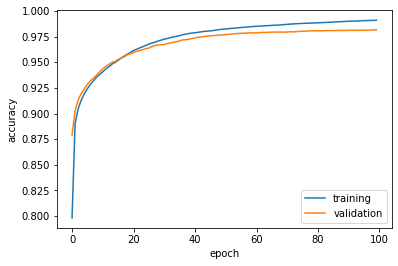

In [20]:
# accuracy
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

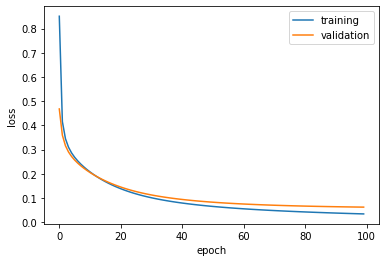

In [21]:
# loss
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

## Model Evaluation with Test Dataset

In [22]:
print("=== EVALUATE MODEL ===")
test_acc = model.accuracy(x_test, y_test)
print("TEST ACCURACY : {}".format(test_acc))

=== EVALUATE MODEL ===
TEST ACCURACY : 0.9838


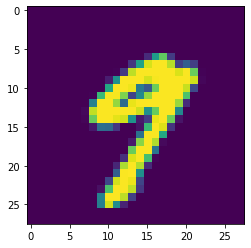

answer:  9
prediction:  9


In [23]:
TCNUM = 20
test_image = x_test[TCNUM].reshape(28, 28)
answer = np.argmax(y_test[TCNUM])
plt.imshow(test_image)
plt.show()

test_image = np.reshape(test_image, (-1, 1, 28, 28))
print("answer: ", answer)
print("prediction: ", np.argmax(model.predict(test_image)))